In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models

In [2]:
device = torch.device("cpu")

In [3]:
!ls 2classes

train  val


In [4]:
!ls 2classes/train

black  white


In [5]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                               ]) 


transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                               ])

training_dataset = datasets.ImageFolder('2classes/train', transform = transform_train)
validation_dataset = datasets.ImageFolder('2classes/val', transform = transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20, shuffle=False)

In [6]:
print("train_len:", len(training_dataset))
print("val_len:", len(validation_dataset))

train_len: 150
val_len: 45


In [7]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image*np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  return image

In [8]:
classes = ['black', 'white']

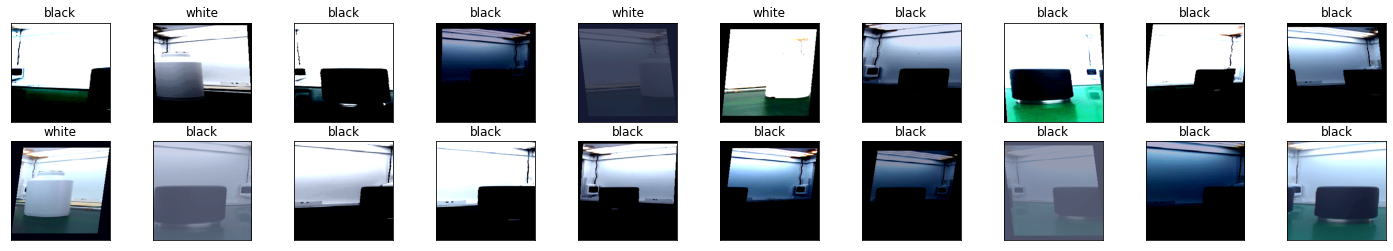

In [9]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize = (25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [10]:
model = models.alexnet(pretrained=True)

In [11]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [12]:
for param in model.features.parameters():
  param.requires_grad = False

In [13]:
import torch.nn as nn
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)
print(model.classifier[6].out_features)

2


In [14]:
for param in model.classifier[6].parameters():
    param.requires_grad = True

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) # try different learning rates to see how model works, lower learning rate cause overfiting

In [16]:
epochs = 10
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):

  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)


  else:
    with torch.no_grad():
     for val_inputs, val_labels in validation_loader:
      val_inputs = val_inputs.to(device)
      val_labels = val_labels.to(device)
      val_outputs = model(val_inputs)
      val_loss = criterion(val_outputs, val_labels)

      _, val_preds = torch.max(val_outputs, 1)
      val_running_loss += val_loss.item()
      val_running_corrects += torch.sum(val_preds == val_labels.data)


    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float()/ len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print('epoch:', (e+1))
    print('training loss: {:.4f}, acc{:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc{:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

epoch: 1
training loss: 0.0235, acc0.7733
validation loss: 0.0104, validation acc1.0000
epoch: 2
training loss: 0.0065, acc0.9733
validation loss: 0.0007, validation acc1.0000
epoch: 3
training loss: 0.0066, acc0.9467
validation loss: 0.0002, validation acc1.0000
epoch: 4
training loss: 0.0041, acc0.9867
validation loss: 0.0001, validation acc1.0000
epoch: 5
training loss: 0.0032, acc0.9800
validation loss: 0.0003, validation acc1.0000
epoch: 6
training loss: 0.0027, acc0.9800
validation loss: 0.0001, validation acc1.0000
epoch: 7
training loss: 0.0038, acc0.9600
validation loss: 0.0003, validation acc1.0000
epoch: 8
training loss: 0.0028, acc0.9867
validation loss: 0.0000, validation acc1.0000
epoch: 9
training loss: 0.0018, acc0.9867
validation loss: 0.0000, validation acc1.0000
epoch: 10
training loss: 0.0005, acc1.0000
validation loss: 0.0000, validation acc1.0000


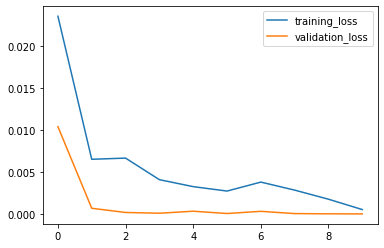

In [17]:
plt.plot(running_loss_history, label = "training_loss")
plt.plot(val_running_loss_history, label = "validation_loss")
plt.legend()

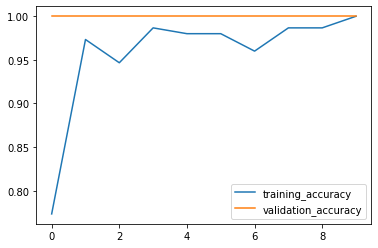

In [18]:
plt.plot(running_corrects_history, label = "training_accuracy")
plt.plot(val_running_corrects_history, label = "validation_accuracy")
plt.legend()

In [19]:
!pip3 install pillow==5.2.0

  Using cached Pillow-5.2.0.tar.gz (14.5 MB)
Using legacy 'setup.py install' for pillow, since package 'wheel' is not installed.
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0
    Running setup.py install for pillow ... done
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

matplotlib 3.5.0 requires pillow>=6.2.0, but you'll have pillow 5.2.0 which is incompatible.
You should consider upgrading via the '/home/lihang/chenggui/811test/.env/bin/python3.8 -m pip install --upgrade pip' command.


In [20]:
import PIL.ImageOps

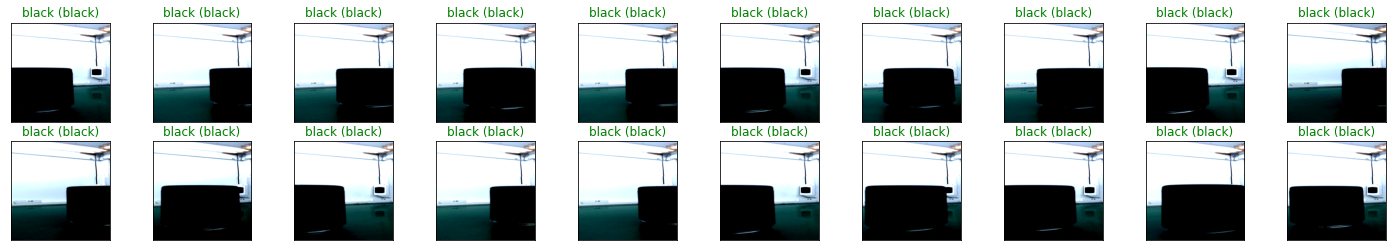

In [21]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images = images.to(device)
lables = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color = ("green" if preds[idx]==labels[idx] else "red"))

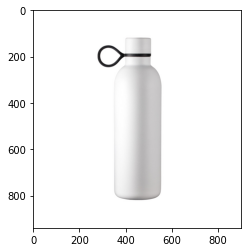

In [22]:
import requests
from PIL import Image

img2 = Image.open(r'test/3.jpg')
plt.imshow(img2)

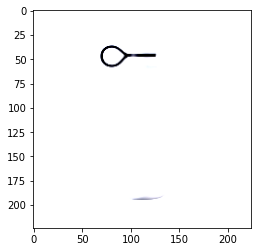

In [23]:
img2 = transform(img2)
plt.imshow(im_convert(img2))

In [24]:
image2 = img2.to(device).unsqueeze(0)
output = model(image2)
_, pred = torch.max(output, 1)
print(f'Predicted Class: {classes[pred.item()]}')
print('Actual Class: white')

Predicted Class: black
Actual Class: white


### Accredit
Alexnet Implementation code of this notebook is based on the source code of the udemy online course "PyTorch for Deep Learning and Computer Vision" by Rayan Slim, Jad Slim, Amer Sharaf, Sarmad Tanveer.